<a href="https://colab.research.google.com/github/zhong338/MFM-FM5222/blob/main/Week13_lectureSlides.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FM 5222

# Week 13


## Agenda


* MCMC with continous distributions
* Metropolis Algorithm
* MCMC regression
* Real data example








## Discete to Continous probabilities distributions


Previously, we discussed Markov Chains when there are discrete states.  We notes that the transition matrix $T$ changes the kth probability distribution $\Psi_k$ into the $\Psi_{k+1} = T \Psi_k$


We noted that under the condition $T$ is regular, the sequence $\Psi_k \to \Psi^*$ where $\Psi^* = T\Psi^*$


We now wish to move to the continuous case where we will be changing PDF's via a Markov transition.   That is,

give a PDF $g_k(\theta)$, we have transformation $T$ that gives another PDF $g_{k+1} = Tg_k$


Like the discrete case, the transform will tell us if we are some point $x$, how likely are we to move to a point $y$.   That is, $T$ will specify a conditional pdf $T(y|x)$


Hence we can construct the new PDF via

$$g_{k+1}(y) = \int T(y|x)g_k(x) dx$$


In practice, what we will want from $T(y|x)$ is that it easy to sample from.  Becaues we don't actually perform the integration. Instead, we use Monte Carlo as follows:


We start with some $x_0$ and create $x_1$ by sampling from $T(y|x_0)$.    

We then create $x_2$ by sampling from $T(y|x_1)$.

If certain convergence conditions are met (similar to what we had with transition matrices), no matter what $x_0$ we start with, this chain will converge to a steady state distribution.  Meaning that after a 'burn-in' period, the $x_k$'s observed will be distributed according to the stationary distribution $g^*$ where


$$g^*(y) = \int T(y|x)g^*(x) dx$$




#### Example

Suppose that we are working on $[0,1]$.   Our transition sampling rule will be

$x_{x+1} = x_k + q(U;x_k)$ where

$q(u;x) = \begin{cases} u, x_k + u \in [0,1] \\ 0, \text{otherwise} \end{cases}$

and

$U \sim \mathrm{Unif}(-.1, .2)$


In other words, given an $x_k$, we peturbate from $x_k$ by a draw from an asymetric uniform distribution.  However, if we go out side our original domain, we just repeat $x_k$.  That is, we reject the candidate choice.

Let's generate samples and see if this appears to converge.









In [ ]:
! pip install yfinance

     |████████████████████████████████| 6.4 MB 7.9 MB/s 
     |████████████████████████████████| 63 kB 946 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss

from scipy.integrate import quad



In [ ]:
# A new trick 

plt.rcParams['figure.figsize'] = [15, 10]

In [ ]:
np.random.seed(103)

N = 2000
x0 = .5
x = np.zeros(N+1)
x[0] = x0

q = lambda u,x: u*(x+u >=0)*(x+u <=1)

for k in range(N):
    u = ss.uniform.rvs(loc = -.1, scale = .3)
    x[k+1] = x[k] + q(u, x[k])

    
    

Let's plot the chain:

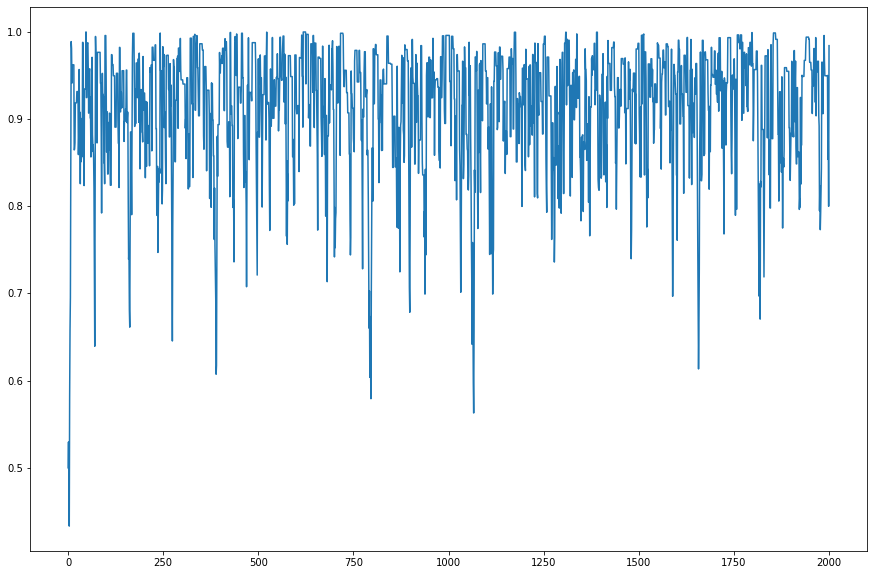

In [ ]:
plt.plot(x)
plt.show()

This looks like it converges pretty quickly.  Let's try a differnt starting point

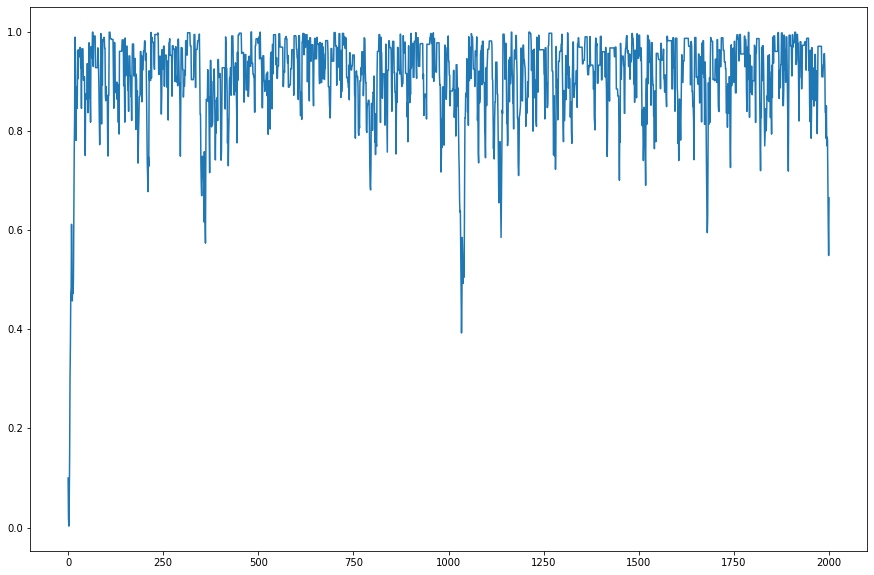

In [ ]:

N = 2000
x0 = .1
x = np.zeros(N+1)
x[0] = x0

q = lambda u,x: u*(x+u >=0)*(x+u <=1)

for k in range(N):
    u = ss.uniform.rvs(loc = -.1, scale = .3)
    x[k+1] = x[k] + q(u, x[k])
    
  
plt.plot(x)
plt.show()
    

Now let's make a histogram of the results assuming a burn-in of $250$.

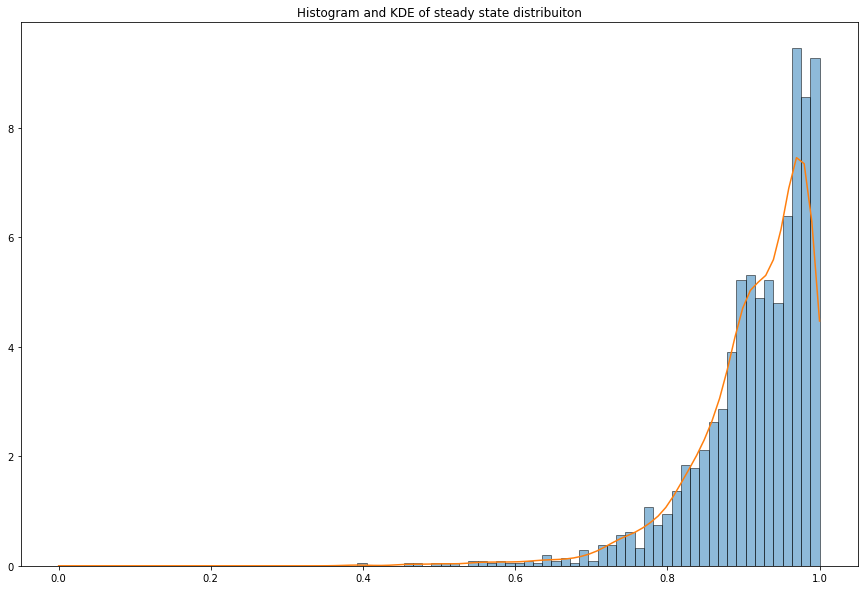

In [ ]:
t = np.linspace(0,1,100)



plt.hist(x[250:], bins = 50, edgecolor = 'black', alpha = .5, density = True)

plt.plot(t, ss.gaussian_kde(x[250:])(t))

plt.title("Histogram and KDE of steady state distribuiton")


plt.show()
    
    

And just to convince ourselvess that this is converging, we run it a lot longer.

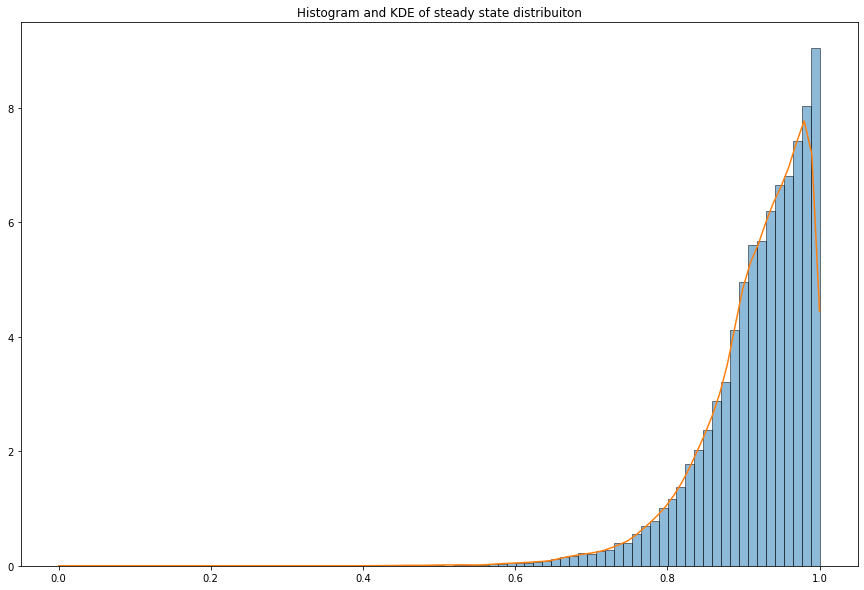

In [ ]:

N = 20000
x0 = .1
x = np.zeros(N+1)
x[0] = x0

q = lambda u,x: u*(x+u >=0)*(x+u <=1)

for k in range(N):
    u = ss.uniform.rvs(loc = -.1, scale = .3)
    x[k+1] = x[k] + q(u, x[k])
    
    
plt.figure(figsize = (15,10))

plt.hist(x[250:], bins = 50, edgecolor = 'black', alpha = .5, density = True)

plt.plot(t, ss.gaussian_kde(x[250:])(t))


plt.title("Histogram and KDE of steady state distribuiton")

plt.show()    

So, we can find the properties of the steady state distribution that follows from this transformation rule via simulation.  Finding it by numerical integration on the other hand would be very computationally demanding. 


## What is the point?

In Baysian analysis, we are faced with the following situation:

We have a prior distribution $g(\theta)$ and have observed $N$ samples $(x_1,x_2, ...,x_N)$  from a known distribuiton with PDF $f_X(x;\theta)$.

We therefore have a posterior PDF (for $\theta$) given by


$$g(\theta| x_1,x_2,...,x_N) = \frac{\left(\Pi_{k=1}^N f_X(x_k;\theta \right) g(\theta)}{\int \left(\Pi_{k=1}^N f_X(x_k;\theta \right) g(\theta) d\theta}$$

Or

$$g(\theta| x_1,x_2,...,x_N) = \frac{1}{C} \left(\Pi_{k=1}^N f_X(x_k;\theta \right) g(\theta)$$

Where $C = \int \left(\Pi_{k=1}^N f_X(x_k;\theta \right) g(\theta) d\theta$ just ensures that the posterior integrates to $1$.


We have already observed that understanding the posterior via integration can be very difficult computationally. 

The idea in MCMC is this:

We will construct a Markov Chain that is


1) Easy to simulate

and

2) Will have $g(\theta| x_1,x_2,...,x_N)$ as its steady-state distribution.




## Metropolis Algorithm

The Metropolis is the earliest and most staight forward algoritms for achieving this.   It does require that we can evaluate the numerator: 

$h(\theta) = \left(\Pi_{k=1}^N f_X(x_k;\theta \right) g(\theta)$

But we do not need to evaluate the constant (which is the computational headache).


Here is the transition rule:

Choose a nice, easy to sample from, "sampling" distribution. For Metropolis, we will require that this be symmetric.   (note that in the above example, the sampling distribution was uniform but not symmetric).

A common choice is the normal distribution.  Let's assume that (with some standard deviation $\eta$).


Start with any $\theta_0$.  


The transition rule will be:

$\theta_{k+1} = \theta_k + Q(Y,\theta_k) Y$  


where

$Q(y,t)$ is a Bernoulli trial with success probability $p = \mathrm{Min}\left(\frac{h(t+y)}{h(t)},1\right)$

and 

$Y \sim \mathcal{N}(0, \eta^2)$


OK, let's unpack this.

You want to pertubate your previous choice but a draw from the Guassian distribution.  But,like the previous example, you don't always accept the choice.

If the new point is has higher posterior liklihood that the current point, we automatically accept the new point. However, if it is less likely, we accept with a probability equal to the proportional liklihood.  The more we have moved away from areas of higher liklihood, the more likely we will reject the  new point.

### Example of Metropolis

Let's do a quick example and then argue why this works. 

Our example will be coin flipping.   We will start (again) with a uniform prior and let's say we flip 10 times oberving $8$ heads.  


We can quickly calculate that

$$h(\theta) = \theta^8 (1-\theta)^2$$



Let's code up our MCMC chain.

In [ ]:
N = 2000
x0 = .1
x = np.zeros(N+1)
x[0] = x0

eta = .2

h = lambda t: t**8 *(1-t)**2*(t >=0)* (t<=1)

Q = lambda y,t: ss.binom.rvs(n=1, p = min(h(y+t)/h(t), 1))

for k in range(N):
    y = ss.norm.rvs(scale = eta)
    x[k+1] = x[k] + Q(y, x[k])*y
    
   
    
    

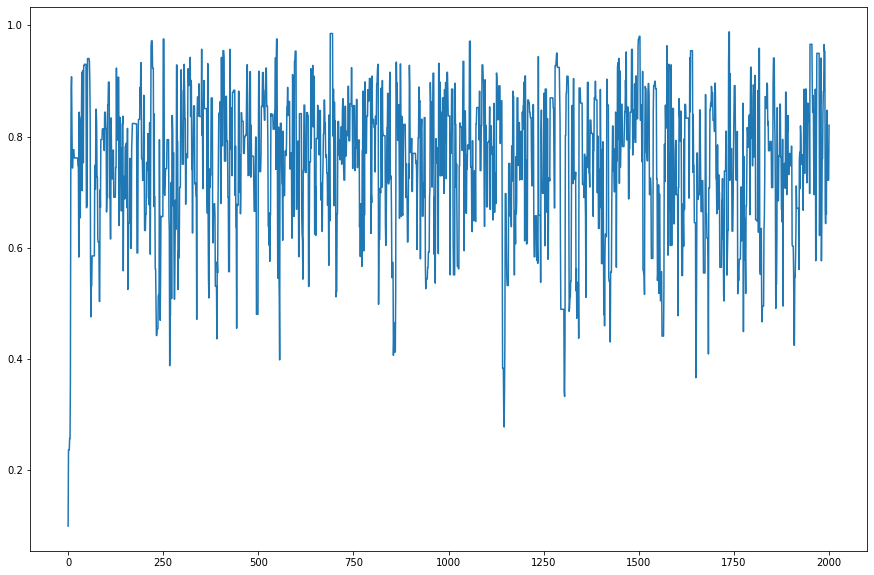

In [ ]:
plt.plot(x)

plt.show()

We will again assume convergence after a "burn-in" of 250.

Let's plot the posterior, it's KDE, and the true posterior (which we know is Beta(9,3))

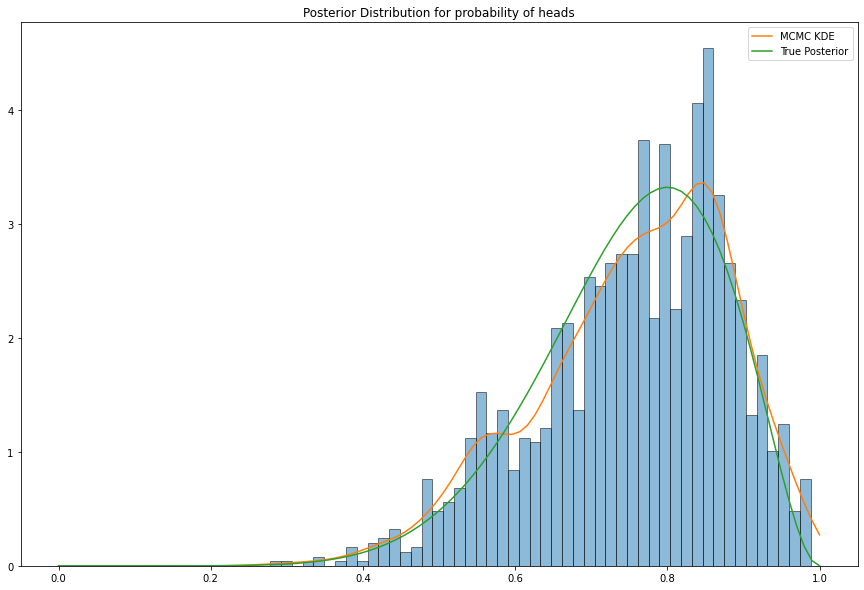

In [ ]:
plt.figure(figsize = (15,10))

plt.hist(x[250:], bins = 50, edgecolor = 'black', alpha = .5, density = True)


plt.plot(t, ss.gaussian_kde(x[250:])(t), label= "MCMC KDE")

plt.plot(t, ss.beta.pdf(t,9,3), label = "True Posterior")

plt.legend()


plt.title("Posterior Distribution for probability of heads")

plt.show()

### Why does this work?


The chain converges to our target distribution.  Convergence is not surprising since, as we saw in the matrix case, what we need to for convergence is not that that demanding.

But why did it converge to the target distribution?


They key is something called the "detailed balancing" condition.

Specifically, consider the likelihood of transitioning from $x$ to $y$.   Under Metropolis, this will be

$$T(y|x) = \begin{cases}\frac{1}{\eta}\phi\left(\frac{y-x}{\eta} \right), \frac{h(y)}{h(x)} >1\\
\frac{1}{\eta}\phi\left(\frac{y-x}{\eta} \right)\frac{h(y)}{h(x)},\frac{h(y)}{h(x} < 1 \end{cases} $$


Now our target distribution is $g(x) = \frac{h(x)}{C}$ 


Observe that 

$$T(y|x)g(x) =  T(y|x)\frac{h(x)}{C} \\
=  \frac{1}{C}\begin{cases}\frac{1}{\eta}\phi\left(\frac{y-x}{\eta} \right)h(x),& h(y) >h(x)\\
\frac{1}{\eta}\phi\left(\frac{y-x}{\eta} \right)h(y), & h(y) < h(x) \end{cases} \\
= \frac{1}{C}\frac{1}{\eta}\phi\left(\frac{y-x}{\eta} \right)\mathrm{Min}(h(x), h(y))\\
=T(x|y)g(y)$$

This is the detailed balancing condition. 

Now consider:

$$ \int T(y|x)g(x) dx =\int T(x|y)g(y) dx\\
=  g(y)$$

Hence, $g(y)$ is the steady state distribution.

## Beyond Metropolis

The algorithm used in pymc3 is not by default Metropolis, though you can specify it.  It uses something called "No U Turn Sampler" or NUTS.

The basic scheme is similar.  You construct a Markov Chain that converges to the target distribution.  It is just done in a more  "clever" (and complicated) fashion.

One of the key drawbacks however is that, in order to execute the NUTS sampler, you need to be able not only to evaluate the numerator $h(\theta)$, but also its gradient.  Since this involves a product of many observations, it it very cumbersome to do by hand. However, certain softwares can "automatically" perform such differenatiation for you, provided the function $f_X(x;\theta)$ is tractable.   

When that is not the case, you may need to resort to the slower Metropolis or Metrpolis-Hastings algorithm.



## MCMC Regression


One nice thing about MCMC is that you can actually use it as a way to do regression.  Instead of getting point estimates of the parameters, you get a joint distribution.  This can be useful when you have (for example) high leverage points.  


Let's create somee fake data examples.

In [ ]:
import pymc3 as pm

import arviz as az

Our fake data will be $y = 3x + \epsilon$ where

$\epsilon \sim \mathcal{N}(0, 2^2)$


Note that there is no intercept, but the modeler will not know that.

In [ ]:

np.random.seed(1171)
x = np.random.uniform(low = 0, high = 10, size = 25)

y = 3*x + np.random.normal(scale = 2, size = 25)

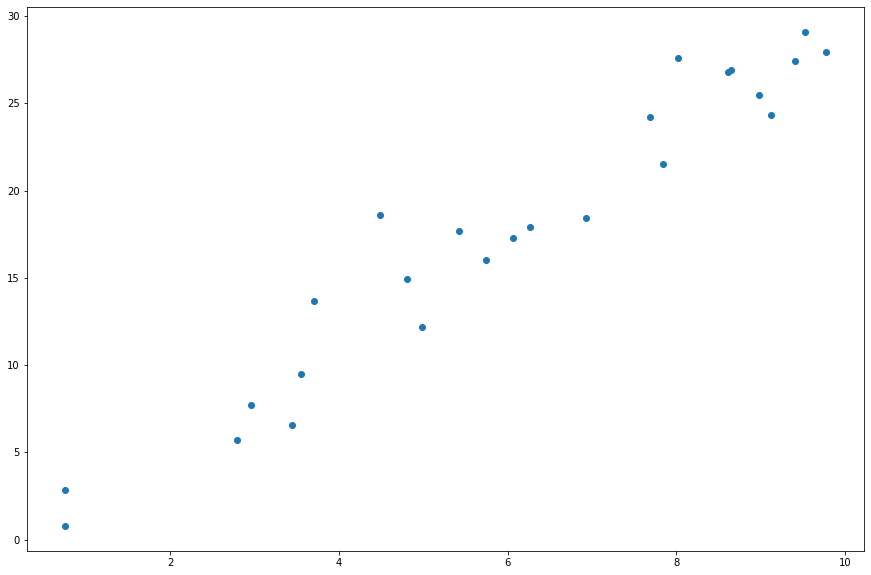

In [ ]:
plt.scatter(x,y)
plt.show()

We will first fit with OLS, as we might natuarlly do.

In [ ]:
import statsmodels.api as sm

In [ ]:
xC = sm.add_constant(x)

OLSmodel = sm.OLS(y, xC)
result = OLSmodel.fit()

print("Intercept estimate is ", result.params[0])

print("Slopeestimate is ", result.params[1])


print("estimated standard residual is  ", result.resid.std())



Intercept estimate is  -0.583408171800731
Slopeestimate is  3.0326584674806703
estimated standard residual is   2.0826467178781836


Let add this to our plot.

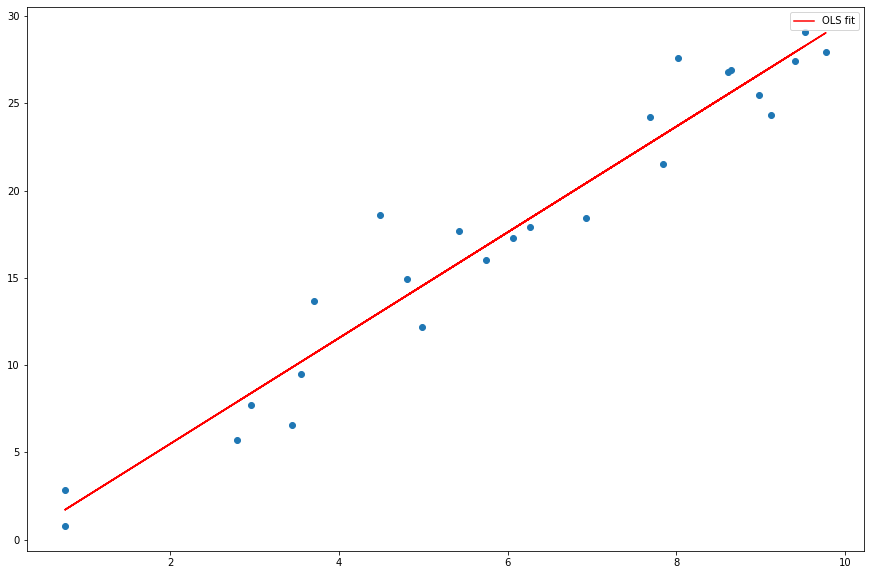

In [ ]:
plt.scatter(x,y)

plt.plot(x, result.params[0] + result.params[1]*x, color = 'r', label = "OLS fit")

plt.legend()
plt.show()

In [ ]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     349.9
Date:                Fri, 22 Apr 2022   Prob (F-statistic):           2.07e-15
Time:                        00:05:29   Log-Likelihood:                -53.814
No. Observations:                  25   AIC:                             111.6
Df Residuals:                      23   BIC:                             114.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5834      1.067     -0.547      0.590      -2.791       1.624
x1             3.0327      0.162     18.706      0.000       2.697       3.368
==============================================================================
Omnibus:                        4.175   Durbin-Watson:                   1.296
Prob(Omnibus):                  0.124   Jarque-Bera (JB):                2.719
Skew:                           0.789   Prob(JB):                        0.257
Kurtosis:                       3.346   Cond. No.                         16.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
 dir(result)

['HC0_se',
 'HC1_se',
 'HC2_se',
 'HC3_se',
 '_HCCM',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_cache',
 '_data_attr',
 '_get_robustcov_results',
 '_is_nested',
 '_wexog_singular_values',
 'aic',
 'bic',
 'bse',
 'centered_tss',
 'compare_f_test',
 'compare_lm_test',
 'compare_lr_test',
 'condition_number',
 'conf_int',
 'conf_int_el',
 'cov_HC0',
 'cov_HC1',
 'cov_HC2',
 'cov_HC3',
 'cov_kwds',
 'cov_params',
 'cov_type',
 'df_model',
 'df_resid',
 'diagn',
 'eigenvals',
 'el_test',
 'ess',
 'f_pvalue',
 'f_test',
 'fittedvalues',
 'fvalue',
 'get_influence',
 'get_prediction',
 'get_robustcov_results',
 'initialize',
 'k_constant',
 'llf',
 'load',
 'model',


Now we will use MCMC to examine the posterior distributions.



In [ ]:
rmodel= pm.Model()

with rmodel:
    
    #define the priors
    
    alpha = pm.Uniform('alpha', lower = -10, upper = 40)
    beta = pm.Normal('beta', mu =0,sigma = 5)
    
    sigma_e = pm.Lognormal('sigma_e', sigma = 1)
    
    
    
    #define the distribution of the observed variables
    
    resids_obs = pm.Normal('resids_obs', mu =0, sigma = sigma_e ,  observed=y - (alpha + beta*x))

In [ ]:
with rmodel:
    
        trace = pm.sample(1000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma_e, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 8 seconds.


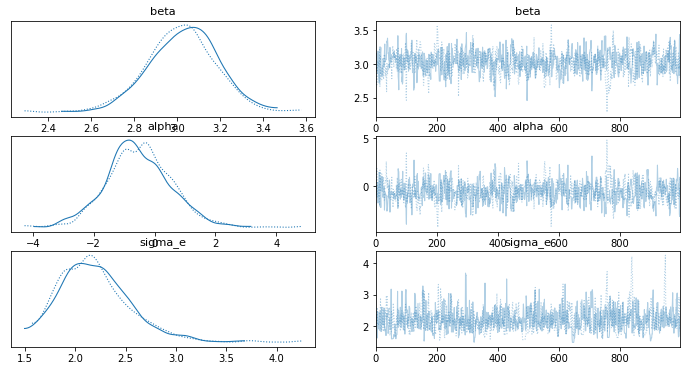

In [ ]:
with rmodel: 
    
    az.plot_trace(trace)

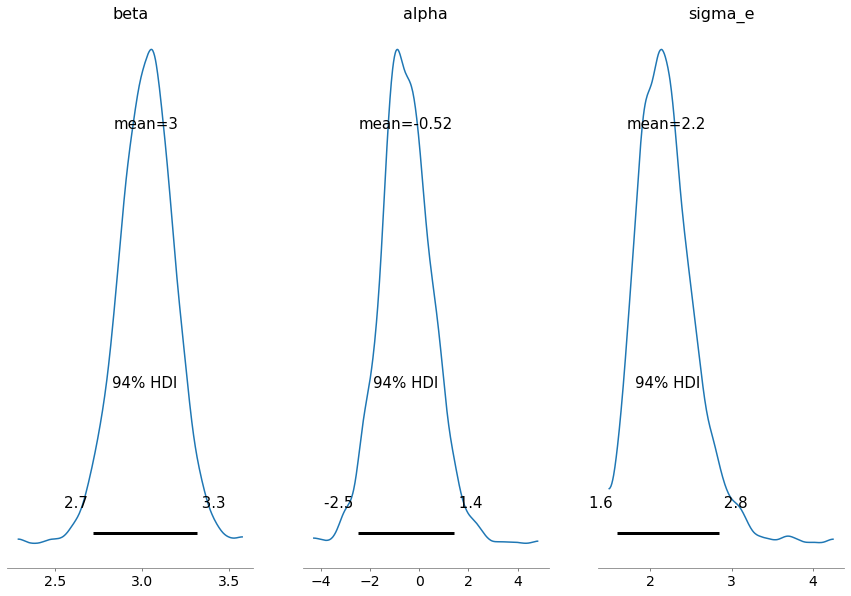

In [ ]:
with rmodel: 
    
      az.plot_posterior(trace, figsize = (15,10))

But we can now examine if there is a relationship (for example) between various slope and intercept estimates.  

What do you expect?

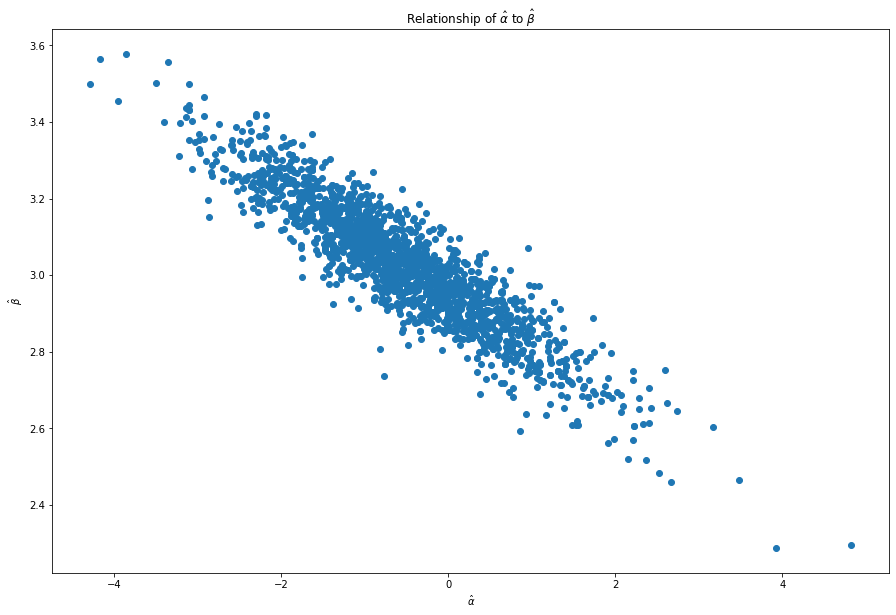

In [ ]:
plt.scatter(trace['alpha'] ,trace['beta'])

plt.xlabel("$\\hat{\\alpha}$")

plt.ylabel("$\\hat{\\beta}$")


plt.title("Relationship of $\\hat{\\alpha}$ to $\\hat{\\beta}$")
plt.show()

We can randomly take some of the data points in our MCMC sample and add those plot lines.

In [ ]:
trace['alpha'][4]

-1.153623066370205

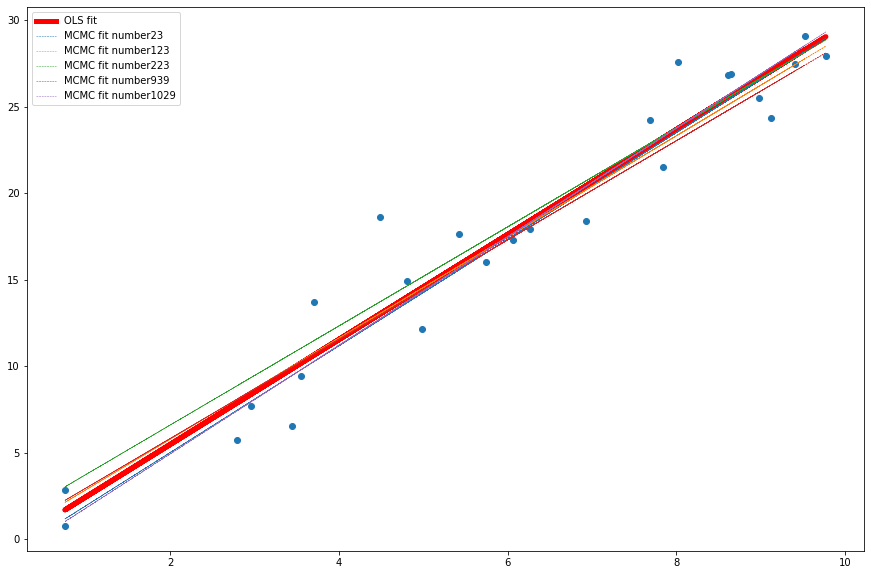

In [ ]:
plt.scatter(x,y)

plt.plot(x, result.params[0] + result.params[1]*x, color = 'r',lw=5 ,label = "OLS fit")

for k in np.array([23,123,223,939, 1029]):
    
    plt.plot(x, trace['alpha'][k] + trace['beta'][k]*x,linestyle = '--',lw=.5, label = "MCMC fit number"+str(k))
    
    


plt.legend()
plt.show()

### Non-normal residuals.

One nice feature of using MCMC isn't so much when the model is OLS, but when it is not.

We create fake data, but the residuals will be heavier tailed (but scaled to be the same variance as previously)



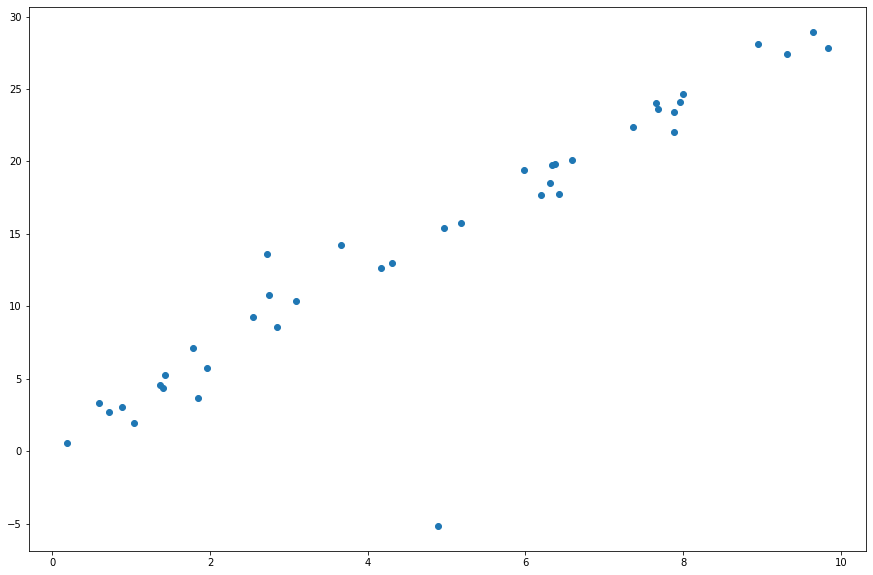

In [ ]:

np.random.seed(5678)
x =np.random.uniform(low =0, high = 10, size = 40)

y = 3*x + ss.t.rvs(df = 2.5, scale = 2/np.sqrt(5), size = 40)


plt.figure(figsize=(15,10))
plt.scatter(x,y)
plt.show()


Let's again so OLS first.

In [ ]:
xC = sm.add_constant(x)

OLSmodel = sm.OLS(y, xC)
result = OLSmodel.fit()

print("Intercept estimate is ", result.params[0])

print("Slopeestimate is ", result.params[1])


print("estimated standard residual is  ", result.resid.std())


Intercept estimate is  0.5640794420369936
Slopeestimate is  2.8735143876483686
estimated standard residual is   3.418388023246924


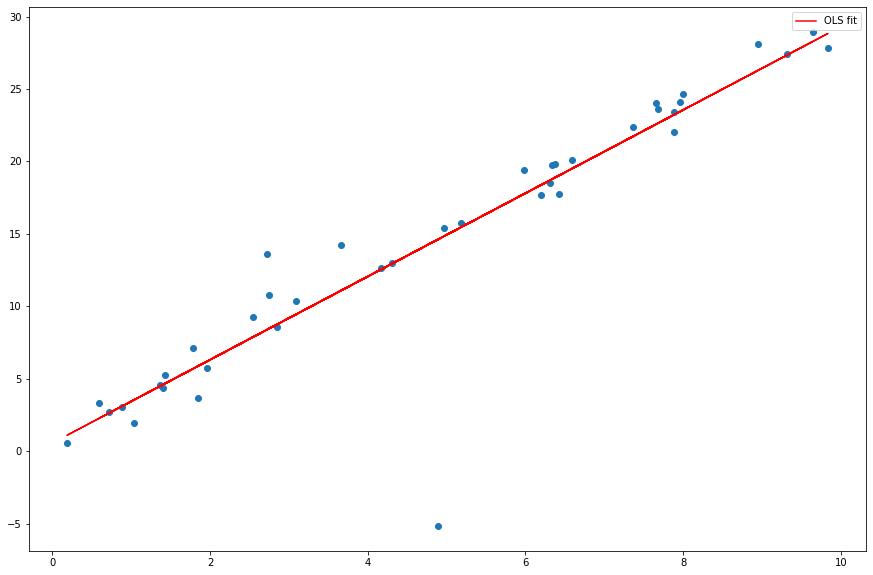

In [ ]:
plt.scatter(x,y)

plt.plot(x, result.params[0] + result.params[1]*x, color = 'r', label = "OLS fit")

plt.legend()
plt.show()

In [ ]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     223.8
Date:                Fri, 22 Apr 2022   Prob (F-statistic):           1.65e-17
Time:                        00:05:51   Log-Likelihood:                -105.92
No. Observations:                  40   AIC:                             215.8
Df Residuals:                      38   BIC:                             219.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5641      1.071      0.527      0.601      -1.603       2.732
x1             2.8735      0.192     14.959      0.000       2.485       3.262
==============================================================================
Omnibus:                       77.343   Durbin-Watson:                   1.179
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1213.236
Skew:                          -4.731   Prob(JB):                    3.54e-264
Kurtosis:                      28.267   Cond. No.                         11.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now we approach using MCMC and the "correct" model

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [df_e, scale_e, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 12 seconds.


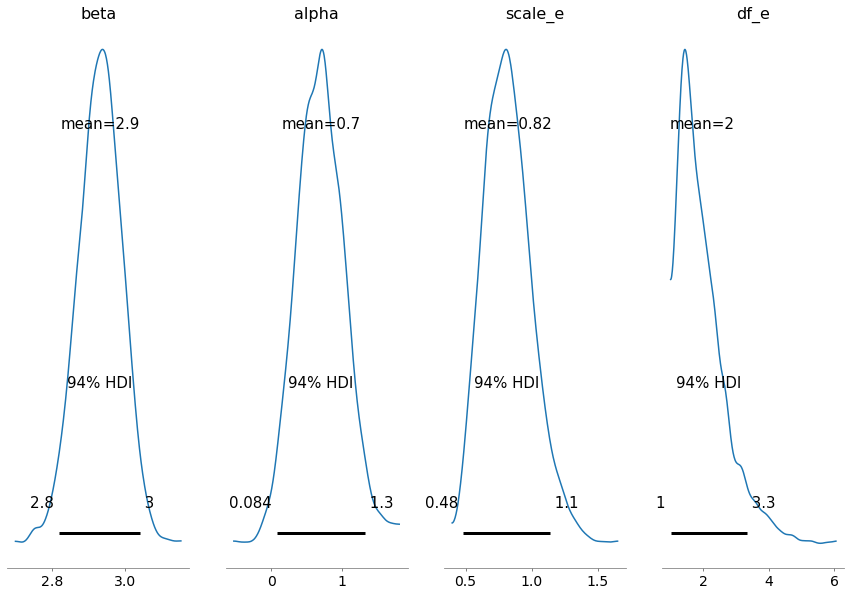

In [ ]:
rmodel_ht= pm.Model()

with rmodel_ht:
    
    #define the priors
    
    alpha = pm.Uniform('alpha', lower = -10, upper = 40)
    beta = pm.Normal('beta', mu =0,sigma = 5)
    
    scale_e = pm.Lognormal('scale_e', sigma = 1)
    
    df_e = pm.Uniform('df_e', lower =1, upper = 30)
    
    
    
    #define the distribution of the observed variables
    
    resids_obs = pm.StudentT('resids_obs',nu = df_e, mu =0, sigma = scale_e ,  observed=y - (alpha + beta*x))
    
    trace = pm.sample(1000)
    
    az.plot_posterior(trace, figsize = (15,10))

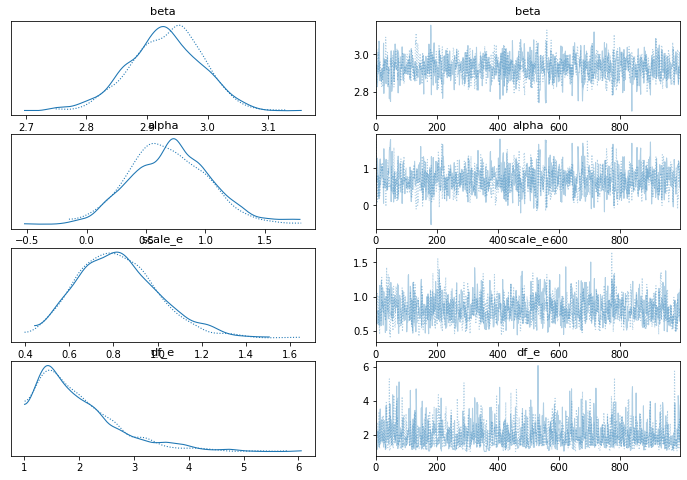

In [ ]:
with  rmodel_ht: 
    
    az.plot_trace(trace)

## Actual Data

Let's revisit our Fama-French 3 factor model and use MCMC to estimate paramaters.




Quoting from Week 11's lecture


### Fama - French 3 factor model

The FF3 model is an extension of CAPM.  Insted of the broad market as the only factor, it also posits two other factors:

1. The excess returns of small cap stocks over large cap stocks
2. The excess returns of high book to market (value) stocks over low book to market (growth) stocks.


We will make our own "version" of this model by using quoted indices and 10 years of history to train over. 


#### Indices

Risk-free rate: Federal Funds rate

Broad Market:  Wilshire5000  (^W5000)

Large Cap:  S&P500  (^GSPC)

Small Cap:  Russell2000 (^RUT)

Value:Vanguard Value Index Fund (VTV)

Growth: Vanguard Growth Index Fund (VUG)




The model will then be


$$R_{j,t} - rf_t = \beta_{j,1} (M_t - rf) + \beta_{j,2} (SC_t - LC_t) + \beta_{j,3} (V_t - G)t) + \epsilon_{j,t}$$


where in general the variables represent log-Returns.


Let's apply this to Disney (DIS), Coca-Cola (KO), and Charles River (CRL).

In [ ]:
import yfinance as yf
import pandas as pd
import pandas_datareader.data as dr




In [ ]:
start = '2010-01-01'
end = '2022-03-01'


stickers = ['DIS', 'KO','CRL' ]

itickers =['^W5000', '^GSPC', '^RUT', 'VTV',"VUG"] 


stocks = yf.download(stickers,start = start, end = end )

indices = yf.download(itickers,start = start, end = end )


rf = dr.DataReader(['DFF'], 'fred', start = start, end= end)

[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  5 of 5 completed


In [ ]:
# Following week 11 

Srets = np.log(stocks.Close).diff()

Irets = np.log(indices.Close).diff()


Srets['rfd'] = rf/252

Irets['rfd'] = rf/252

data = pd.DataFrame()




data['DISer'] =Srets['DIS'] - Srets.rfd

data['KOer'] = Srets['KO'] - Srets.rfd

data['CRLer'] = Srets['CRL'] - Srets.rfd




data['M_er'] = Irets['^W5000'] - Irets.rfd

data['SMB'] = Irets['^RUT'] - Irets['^GSPC']

data['HML'] = Irets['VTV'] - Irets['VUG']

data = data.dropna()

data.head()

,DISer,KOer,CRLer,M_er,SMB,HML
Date,,,,,,
2010-01-05,-0.002974,-0.012647,0.005168,0.002652,-0.005629,0.000699
2010-01-06,-0.005805,-0.000831,-0.013895,0.001499,-0.001391,0.002910
2010-01-07,-0.000083,-0.002885,0.038177,0.003563,0.002288,0.004032
2010-01-08,0.001133,-0.019119,-0.007102,0.002828,0.001149,-0.005054
2010-01-11,-0.016882,0.019668,0.009689,0.000994,-0.002630,0.005178


### Disney




In [ ]:
DISfit =  sm.OLS(data.DISer,data.loc[:,['M_er',"SMB", 'HML'] ] ).fit()

DISfit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  DISer   R-squared (uncentered):                   0.512
Model:                            OLS   Adj. R-squared (uncentered):              0.512
Method:                 Least Squares   F-statistic:                              1066.
Date:                Fri, 22 Apr 2022   Prob (F-statistic):                        0.00
Time:                        00:06:16   Log-Likelihood:                          9343.2
No. Observations:                3047   AIC:                                 -1.868e+04
Df Residuals:                    3044   BIC:                                 -1.866e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
M_er           1.0005      0.019     52.384      0.000       0.963       1.038
SMB            0.0100      0.033      0.300      0.764      -0.055       0.075
HML            0.2977      0.036      8.347      0.000       0.228       0.368
==============================================================================
Omnibus:                      959.084   Durbin-Watson:                   2.117
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            35104.021
Skew:                           0.809   Prob(JB):                         0.00
Kurtosis:                      19.549   Cond. No.                         2.23
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now we fit using MCMC and assuming Student T resisuals.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [scale, df, hml, smb, mkt]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 13 seconds.


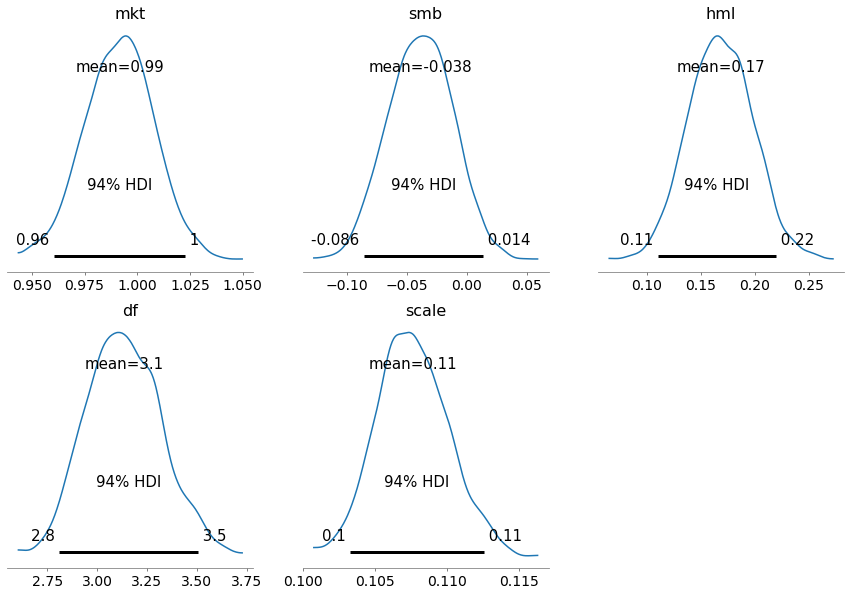

In [ ]:
model_Dis = pm.Model()


with model_Dis:
    
    mkt = pm.Uniform('mkt', lower = -2, upper = 2)
    
    smb = pm.Uniform('smb',lower = -2, upper = 2 )
    
    hml = pm.Uniform('hml',lower = -2, upper = 2 )
    
    df = pm.Uniform('df', lower = 1, upper = 30)
    
    scale = pm.Lognormal('scale')/np.sqrt(252)
    
    
    observed = np.array(data.DISer) - (mkt* np.array(data.M_er) + smb* np.array(data.SMB) + hml*np.array(data.HML))
    
    
    
    resids_obs = pm.StudentT('resids_obs',nu = df, mu =0, sigma = scale ,  observed=observed)
    
    trace = pm.sample(1000)
    
    az.plot_posterior(trace, figsize = (15,10))
    
    
    
    

### Coca Cola

In [ ]:
KOfit =  sm.OLS(data.KOer,data.loc[:,['M_er',"SMB", 'HML'] ] ).fit()

KOfit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   KOer   R-squared (uncentered):                   0.501
Model:                            OLS   Adj. R-squared (uncentered):              0.501
Method:                 Least Squares   F-statistic:                              1019.
Date:                Fri, 22 Apr 2022   Prob (F-statistic):                        0.00
Time:                        00:06:56   Log-Likelihood:                          10326.
No. Observations:                3047   AIC:                                 -2.065e+04
Df Residuals:                    3044   BIC:                                 -2.063e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
M_er           0.7521      0.014     54.360      0.000       0.725       0.779
SMB           -0.4084      0.024    -17.019      0.000      -0.455      -0.361
HML            0.5052      0.026     19.556      0.000       0.455       0.556
==============================================================================
Omnibus:                      758.069   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11912.402
Skew:                          -0.749   Prob(JB):                         0.00
Kurtosis:                      12.570   Cond. No.                         2.23
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [scale, df, hml, smb, mkt]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 14 seconds.


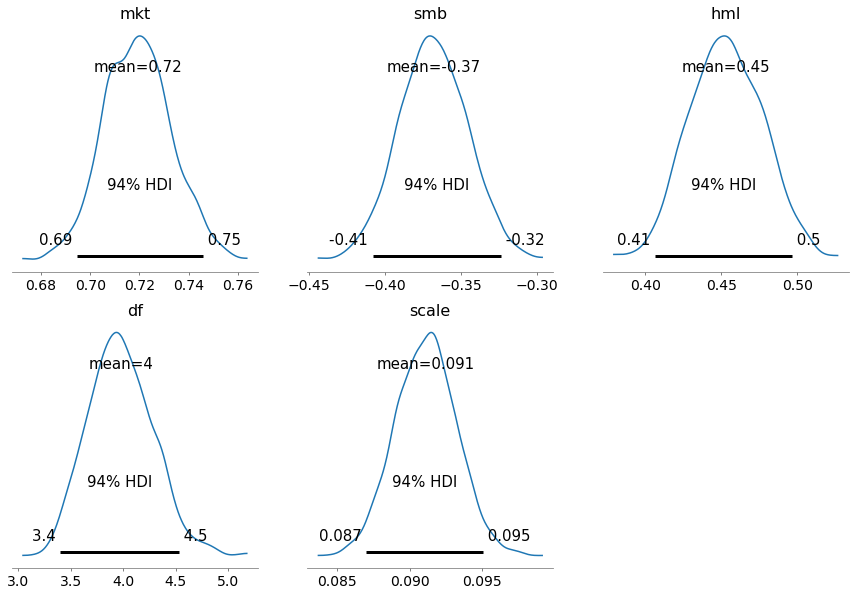

In [ ]:
model_KO = pm.Model()


with model_KO:
    
    mkt = pm.Uniform('mkt', lower = -2, upper = 2)
    
    smb = pm.Uniform('smb',lower = -2, upper = 2 )
    
    hml = pm.Uniform('hml',lower = -2, upper = 2 )
    
    df = pm.Uniform('df', lower = 1, upper = 30)
    
    scale = pm.Lognormal('scale')/np.sqrt(252)
    
    
    observed = np.array(data.KOer) - (mkt* np.array(data.M_er) + smb* np.array(data.SMB) + hml*np.array(data.HML))
    
    
    
    resids_obs = pm.StudentT('resids_obs',nu = df, mu =0, sigma = scale ,  observed=observed)
    
    trace = pm.sample(1000)
    
    az.plot_posterior(trace, figsize = (15,10))

### Charles River Labs

In [ ]:
CRLfit =  sm.OLS(data.CRLer,data.loc[:,['M_er',"SMB", 'HML'] ] ).fit()

CRLfit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  CRLer   R-squared (uncentered):                   0.437
Model:                            OLS   Adj. R-squared (uncentered):              0.436
Method:                 Least Squares   F-statistic:                              787.3
Date:                Fri, 22 Apr 2022   Prob (F-statistic):                        0.00
Time:                        00:07:25   Log-Likelihood:                          8583.5
No. Observations:                3047   AIC:                                 -1.716e+04
Df Residuals:                    3044   BIC:                                 -1.714e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
M_er           0.9836      0.025     40.133      0.000       0.936       1.032
SMB            0.2624      0.043      6.173      0.000       0.179       0.346
HML           -0.4212      0.046     -9.205      0.000      -0.511      -0.331
==============================================================================
Omnibus:                      863.503   Durbin-Watson:                   2.046
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            34988.530
Skew:                          -0.616   Prob(JB):                         0.00
Kurtosis:                      19.555   Cond. No.                         2.23
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [scale, df, hml, smb, mkt]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 14 seconds.


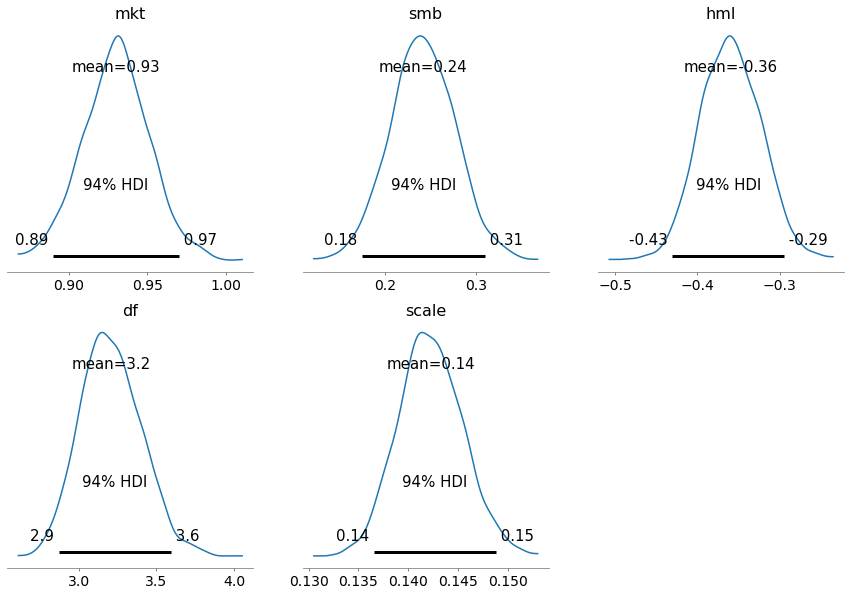

In [ ]:
model_CRL = pm.Model()


with model_CRL:
    
    mkt = pm.Uniform('mkt', lower = -2, upper = 2)
    
    smb = pm.Uniform('smb',lower = -2, upper = 2 )
    
    hml = pm.Uniform('hml',lower = -2, upper = 2 )
    
    df = pm.Uniform('df', lower = 1, upper = 30)
    
    scale = pm.Lognormal('scale')/np.sqrt(252)
    
    
    observed = np.array(data.CRLer) - (mkt* np.array(data.M_er) + smb* np.array(data.SMB) + hml*np.array(data.HML))
    
    
    
    resids_obs = pm.StudentT('resids_obs',nu = df, mu =0, sigma = scale ,  observed=observed)
    
    trace = pm.sample(1000)
    
    az.plot_posterior(trace, figsize = (15,10))

## Summary

We

* Extended Markov Chains from discrete distributions to continous ones
* Constructed Mone Carlo Markov Chains to similate the steady state distributions
* We xplained how the Metropolis algorithm works for Baysian posteriors
* W